# Explanation and validation of solar radiation calculation
---
### based on statistical data from measurements and methods described in *solar engineering for thermal processes ISBN: 978-1-118-67160-3*
---
The functions written below closely resemble the script which wraps these functions.

The only external modules used are: numpy, matplotlib and if you want to use jupyter notebooks, a lot more.

* add angled surfaces, ground reflection

In [1]:
# Required imports
import datetime
import csv
import Get_Radiation as R
import matplotlib.pyplot as plt #pip install matplotlib
import numpy as np # pip install numpy
%matplotlib notebook  

* Solar engineering for thermal processes describes multiple steps to approximate possible solar radiation for a given location and time. The base for these calculations are measurements taken from over the world, this lead to an empirical model.
* However, measurements are available from all over the world. 
    * Instead of using the model to determine all values, the hourly cloudiness index can be calculated with measurements and accurate clear-sky solar radiation calculations. 
    * The Diffuse and direct component are estimated with a correlation on **kt = Qglob/Qext **
        * where Qglob is global radiation and Qext is extraterestial radiation (as seen by the atmosphere) (p.71)
    * The fraction **Id/I** is a function of kt 
        * where Id is diffuse radiation on horizontal plane, I is global radiation on horizontal plane.
___

To be able to accurately approximate real solar radiation (clear and cloudy sky), several steps are taken.
1. first a dataset has to be known for the given location, preferably multiple years in hour data. Global radiation data is fine. From this, average hourly **kt** values are determined for the given dataset. This takes disturbances in the atmosphere into account.
2. The PySolar toolbox is used to calculate global radiation (=! extraterestial radiation). This is used to calculate the value **Qglob,real / Qglob,pysolar** for every datapoint.
    3. from these points, statistical data is saved to be able to generate a similar set with similar statistical properties.
    4. this is where a bigger set becomes better, a year can have 8760 hours. if you have 40 years of data, the standard deviation of 40 datapoints per hour is calculated.
3. The combination of 1 and 2 together with **Id/I** can be used to recreate data for a given location.
___

In [2]:
def CalculateLocalVariation(Filename,lat,lon,verbal=False): # takes KNMI fileformat. Q, (j/mm2), HH(hour of day)are needed at least.
    dates = []
    hourdatakt = [0.0 for i in range(366*24)]
    hourdata = [[] for i in range(366*24)]
    with open(Filename,'r') as csvfile:
          reader = csv.DictReader(csvfile)
          for row in reader:
              try:
                  h = int(row["HH"])
                  h = h-1
                  if h < 10:
                      h = "0%s"%h
                  date = "%s-%s"%(row['YYYYMMDD'],h)
                  date = datetime.datetime.strptime(date,"%Y%m%d-%H")
                  DOY = int(R.solar.GetDayOfYear(date+datetime.timedelta(minutes=30))) #midpoint of hour is needed.
                  HOY = int(R.GetHourOfYear(date))   
                    
                  I = float((int(row["Q"])*100*100))/3600
                  alt,azi,Qsim,Qdir,Qdif = R.GetRad(lat,lon,date)
                  Qext = R.radiation.GetApparentExtraterrestrialFlux(DOY)
                  Ferror = False
                  if(I != 0 and Qsim != 0):
                    Ferror = True
                
                                
                  if Ferror:
                      if hourdatakt[HOY] == 0: # init case
                          hourdatakt[HOY] = (I/Qext)
                      else:
                          hourdatakt[HOY] = ((I/Qext) + hourdatakt[HOY])/2
                      hourdata[HOY].append(I/Qsim)
                  if verbal and Ferror:
                      print "I: {} Sim: {} [I/Qsim]: {} date: {}, HOY:{}".format(I,Qsim,(I/Qext),date,HOY)
              except ValueError:
                  if verbal:
                      print "EOF"
    if verbal:
        print hourdata
    for i in hourdata:
        plt.plot(i)
    plt.ylabel('Hourly kt')
    plt.title('kt(hour) calculated according to Solar Engineering of thermal processes p.71')
    plt.grid(True)
    plt.savefig("hourly.png")
    plt.show()
    return hourdata,hourdatakt



## The above function does 2 things and is designed to take KNMI data;
1. calculate the mean kt value (only mean is needed here)
2. create an array for each hour with **Qglob/Qglob,pysolar**
    3. we need statistical data from these arrays; at least standard deviation and mean value
___
syntax: **HourData,HourDataKt = CalculateLocalKT("DeBilt_1960-2016,5.18,52.1)** this would use the prepared file (or use Twenthe_hourly), which contains 1960 to 2016 in hour steps for 'De Bilt', the Netherlands (latitude 5.18, longitude 52.1). An extra argument can be passed, if set to True it wil return all data it calculates. *Warning: this can slow down the process.*

*Note that the .csv extension is expected for all input files, fill the name **without** .csv.* 
*Exported files are all in .csv format.*

In [3]:
HourData,HourDataKt = R.CalculateLocalVariation("Twenthe_hourly",6.9,52.2)
#HourData = CalculateLocalKT("KNMI_20171107_hourly.txt",5.18,52.1)
#R.ToCSV("hourkt_1960-2016.csv", HourDataKt, fieldnames = ["kt"])

## If you are calculating new values, save* kt* with:
**R.ToCSV("hourkt_1960-2016.csv", hourdataKt, fieldnames = ["Qr/Qext"])**
___
"hourkt_1960-2016.csv" will be the output filename,
___
hourdataKt is created above, this contains the calculated Kt values.
___
If you save a matrix, also set the column names for the resulting file.
fieldnames = ["Qr/Qext"] 

In [4]:
def CalcStats(Array,verbose = False):
    if len(Array) < 1:
        return 0,0,0,0,0,0
    else:
        stdev = np.std(Array)
        mean = np.mean(Array)
        median = np.median(Array)
        variance = np.var(Array)
        Min = np.min(Array)
        Max = np.max(Array)
        if verbose:
            NormDist = np.random.normal(mean,stdev,len(testhour))
            stdevErr = abs(stdev-np.std(NormDist))
            meanErr = abs(mean-np.mean(NormDist))
            medianErr = abs(median-np.median(NormDist))
            varianceErr = abs(variance-np.var(NormDist))
            print "standard deviation: {}, mean: {}, median: {}, variance: {}, min: {}, max: {}".format(stdev,mean,median,variance,Min,Max)
            print "stdevErr: {}, meanErr: {}, medianErr: {}, varianceErr: {}".format(stdevErr,meanErr,medianErr,varianceErr)
        return stdev,mean,median,variance, Min, Max     

## CalcStats
* This function calculates statistical properties for a given dataset.
    * **stdev,mean,median,variance, Min, Max= CalcStats(testhour,True)**
    * If the second argument is set to true, an error check is returned *may slow down process*

standard deviation: 0.133056742745, mean: 0.226978215668, median: 0.253064704976, variance: 0.01770409679, min: 0.0282954627, max: 0.392966338154
stdevErr: 0.0328333473503, meanErr: 0.0217287417258, medianErr: 0.0475557109644, varianceErr: 0.0076593678055


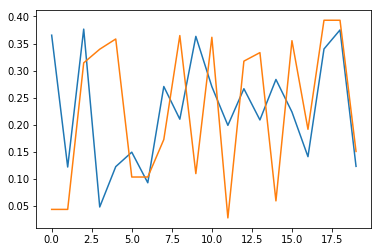

In [4]:
testhour = HourData[3006]
stdev,mean,median,variance, Min, Max= R.CalcStats(testhour,True)
bc = R.TND(stdev,mean,Min,Max,len(testhour))
#bc = np.random.normal(mean,stdev,len(testhour))
plt.plot(bc)
plt.plot(testhour)
plt.show()

# Error check
* Above block defines hour 3006 as testhour
    * the output shows: stdev,measurement - stdev,calculated. As for mean, median and variance.
    * **bc = np.random.normal(mean,stdev,len(testhour))** creates a normal distribution with midpoint:mean and scale:stdev.
        * The same is done in the CalcStats function when the second argument is True (for sanity check)
    * The generated plot shows the original Gglob,measurement/Gglob,Pysolar in blue and the generated version in green.
___
**Note:** The generated set is not the same, this is an estimation. The mean, median, variance and standard deviation are almost the same. This means that this could be an 'option' with equal likelihood.

In [5]:
def CalcStatsSet(HourData):
    HourStats = []
    for i in HourData:
        mu,sig,med,var,Min,Max = CalcStats(i)
        HourStats.append([mu,sig,med,var,Min,Max])
    return HourStats
HourStats = R.CalcStatsSet(HourData)
print len(HourStats)
print len(HourData)
#R.ToCSV("Stats_Twenthe_hourly", HourStats, fieldnames = ["mu","sigma","median","min","max","variance"])

8784
8784


# Calculating Statistical data
### Because of leap years, 8784 hours are taken into account.
* The block above iterates through the [8784 x (No. years)] array
* applies the CalcStats function
* appends the result as an array [mu,sig,med,var,Min,Max] to HourStats.
    * As stated above, multiple rows are needed (matrix) thus the ToCSV needs to know about this.

In [6]:
def GetStats(hourfile="Stats_DeBilt_2017"):
    hour = []
    with open(hourfile,'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            hour.append([float(row["mu"]),float(row["sigma"]),float(row["median"]),float(row["min"]),float(row["max"]),float(row["var"])])
    return hour

hour = R.GetKx("hourkt_Twenthe_hourly.csv")
RestoredStats = R.GetStats("Stats_Twenthe_hourly.csv")
print len(RestoredStats)
testhour = RestoredStats[3006]
print testhour

8784
[0.13305674274546608, 0.22697821566781112, 0.25306470497567796, 0.02829546269998279, 0.39296633815434945, 0.01770409679003314]


# This function restores the .csv file containing statistical data.
* The **RestoredStats** variable below contains exactly the same as before the save.
    * In this case, **HourStats**

In [2]:
Surfaces = [[35,170],[90,170],[35,-10],[90,-10]]# wall and roof angles for stinsburg
c = 0
Fieldnames = []
for i in Surfaces:
    Fieldnames.append("Date_%d_%d_%d"%(i[0],i[1],c))
    Fieldnames.append("Itot_%d_%d_%d"%(i[0],i[1],c))
    Fieldnames.append("Ib_%d_%d_%d"%(i[0],i[1],c))
    Fieldnames.append("Iid_%d_%d_%d"%(i[0],i[1],c))
    Fieldnames.append("Icd_%d_%d_%d"%(i[0],i[1],c))
    Fieldnames.append("Ihd_%d_%d_%d"%(i[0],i[1],c))
    Fieldnames.append("Igr_%d_%d_%d"%(i[0],i[1],c))
    Fieldnames.append("theta_%d_%d_%d"%(i[0],i[1],c))
    c += 1
print Fieldnames

['Date_35_170_0', 'Itot_35_170_0', 'Ib_35_170_0', 'Iid_35_170_0', 'Icd_35_170_0', 'Ihd_35_170_0', 'Igr_35_170_0', 'theta_35_170_0', 'Date_90_170_1', 'Itot_90_170_1', 'Ib_90_170_1', 'Iid_90_170_1', 'Icd_90_170_1', 'Ihd_90_170_1', 'Igr_90_170_1', 'theta_90_170_1', 'Date_35_-10_2', 'Itot_35_-10_2', 'Ib_35_-10_2', 'Iid_35_-10_2', 'Icd_35_-10_2', 'Ihd_35_-10_2', 'Igr_35_-10_2', 'theta_35_-10_2', 'Date_90_-10_3', 'Itot_90_-10_3', 'Ib_90_-10_3', 'Iid_90_-10_3', 'Icd_90_-10_3', 'Ihd_90_-10_3', 'Igr_90_-10_3', 'theta_90_-10_3']


[1, 2, 3]
plotting column 1
plotting column 2
plotting column 3
Value of i:6
value of i2:0
value of i2:1
value of i2:2


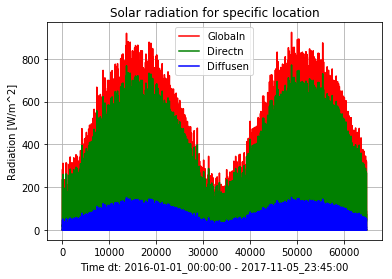

[1, 2, 3, 4, 5, 6]
plotting column 1
plotting column 2
plotting column 3
plotting column 4
plotting column 5
plotting column 6
Value of i:32
value of i2:0
value of i2:1
value of i2:2
value of i2:3
value of i2:4
value of i2:5


IndexError: list index out of range

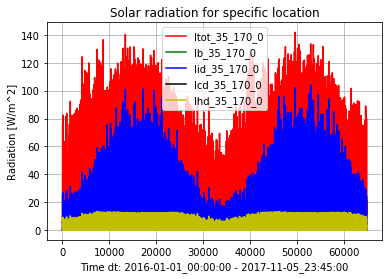

In [3]:
#sample = R.CalcRad("2016-1-1","2017-11-6",6.9,52.2,900)
startdate = "2016-1-1"
stopdate = "2017-11-6"
lat = 6.9 # stinsburg lat & lon
lon = 52.2
dT = 900 # 15 minutes
Ktfile = "hourkt_Twenthe_hourly.csv"
statsfile = "Stats_Twenthe_hourly.csv"

Rhog = None # ground reflection coefficient. is location specific, needs 12 values, 1 per month.
TimeFormat = "%Y-%m-%d_%H:%M:%S" 
plot=True # automatic plotting of results

sample = R.CalcRad(startdate,stopdate,lat,lon,dT,Ktfile,statsfile,Surfaces,Rhog,TimeFormat,plot,Fieldnames)

## The R.Calcrad uses the previous result and some other arguments to create the final set
* The function will work with above arguments but more arguments are possible.
* **CalcRad(startDate,stopDate,latitude,longitude,TimeStep = 3600,KxFile="hourkt_1960-2016.csv",StatFile="Stats_DeBilt_1960-2016",TimeFormat = "%Y-%m-%d_%H:%M:%S")**
    * KxFile="hourkt_1960-2016.csv" refers to the created hourly kx calculation. You can redo this calculation with the given function and use the resulting data.
    * StatFile="Stats_DeBilt_1960-2016" refers to the created hourly stats.
    * Both files are supplied and are valid for De Bilt, The Netherlands (lat:5.18,lon:52.1)
    * TimeFormat = "%Y-%m-%d_%H:%M:%S" can be adjusted to return a different format. See [this](https://docs.python.org/2/library/datetime.html#strftime-strptime-behavior) for formatting options.
    * The maximum timestep is 3600 seconds (1 hour), everything smaller can be chosen.
    * StartDate and stopDate are expected in format "2015-10-12" and are mandatory
    * latitude and longitude are mandatory
* Calculating new Kx and statistical values is advised if the location is different then De Bilt. However, within reasonal distance from De Bilt, calculations should still be accurate.

In [4]:
print len(sample[0][0])
print len(sample[1][0])
print sample[0][0]
print sample[1][0]
col=0
colList = [ sample[0][i][col] for i in xrange(len(sample[0])) ]

NameError: name 'sample' is not defined

In [25]:
%matplotlib notebook 

In [5]:
def PlotSample(sample,PlotList=[[1,2,3]],fieldnames=["Global","Direct","Diffuse"]):
    for L in PlotList:
        plt.figure()
        ColorList = ['r','g','b','k','y']
        colList = []
        print L
        i=0
        for col in xrange(len(sample[0])):
            Plot = False
            for j in L:
                if j == i:
                    print "plotting column {}".format(i)
                    Plot = True
            if Plot:
                temp = [ sample[k][col] for k in xrange(len(sample)) ]
                colList.append(temp)
            i += 1
        date = [ [k] for k in xrange(len(sample)) ]
        print "Value of i:{}".format(i)
        for i in range(len(colList)):
            print "value of i2:{}".format(i)
            plt.plot(date,colList[i],ColorList[i],label=fieldnames[i])
            plt.ylabel('Radiation [W/m^2]')
            plt.xlabel('Time dt: {} - {}'.format(sample[0][0],sample[-1][0]))
            plt.title('Solar radiation for specific location')
            plt.grid(True)
            plt.legend()
    plt.show()
    
    

In [108]:
def SlopeColumnMapping(slopes):
    AmountOfColumns = 6
    counter = 1
    PlotStructure = []
    for i in slopes:
        temp = []
        for j in xrange(AmountOfColumns):
            temp.append(counter)
            counter += 1
        PlotStructure.append(temp)
        counter += 2
    return PlotStructure

print SlopeColumnMapping(Surfaces)

[[1, 2, 3, 4, 5, 6], [9, 10, 11, 12, 13, 14], [17, 18, 19, 20, 21, 22], [25, 26, 27, 28, 29, 30]]


In [6]:
PlotSample(sample[0][0:300])

NameError: name 'sample' is not defined

# result

Plot below shows measured data from 1960 to 2016 and calculated data from 1960 to 2016. Some overestimations occur, but overall the approximation is relatively close.

In [9]:
measured = []
with open("KNMI_20171107_hourly.txt",'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        measured.append(float((int(row["Q"])*100*100))/3600)

# Statistics

The error on standard deviation, mean and variance is small. 

Median, minimum and maximum value can be inaccurate 

In [10]:
Qgc = []
for i in sample:
    Qgc.append(i[1])
print "standard deviation:, mean:,       median:,    variance:,          min:, max:"
print CalcStats(Qgc)
print CalcStats(measured)

standard deviation:, mean:,       median:,    variance:,          min:, max:
(223.27615986000365, 138.86450359078282, 1.9494328233881806e-15, 49852.243561829906, 0.0, 935.64187172268896)
(195.6925251806116, 125.26538187595879, 8.3333333333333339, 38295.564411564308, 0.0, 941.66666666666663)


<IPython.core.display.Javascript object>


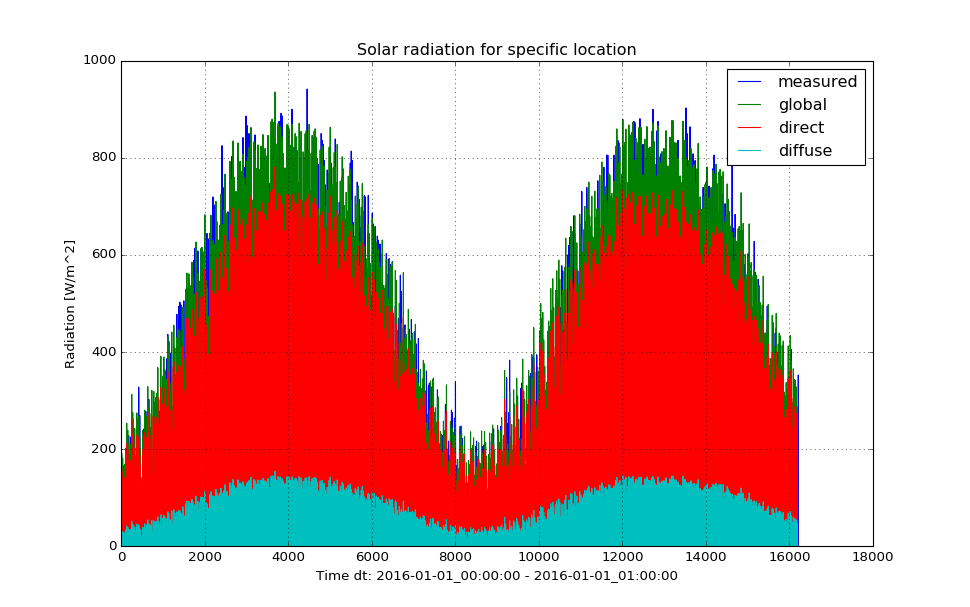

In [16]:
plt.plot(measured,label='measured')
PlotSample(sample)

# Result
* All steps above are wrapped by the function below
 **CreateSet(FileName,Lat,Lon,dT=3600,start="1990-1-1",stop="2000-1-1",plot=False):**
* Remind that KNMI formatted data is expected;
* the needed format is:


 | STN,|YYYYMMDD, |HH,   |T,    |Q,    |   N
 |-----|:---------|:----:|:----:|:----:|:--:
 | 260,|19600101, |   1, |  80, |   0, |   8
 | 260,|19600101, |   2, |  86, |   0, |   7
 | 260,|19600101, |   3, |  83, |   0, |   8
 
 
 * where:
     * **STN** station number, not needed
     * **YYYYMMDD** self explanatory, *mandatory*
     * **HH** hour of day (1-24), *mandatory*
     * **T** Temperature, not needed
     * **Q** Average Radiation over hour [J/mm^2], *mandatory*
     * **N** cloud cover factor [unitless], not needed

In [12]:
def CreateSet(FileName,Lat,Lon,dT=3600,start="1990-1-1",stop="2000-1-1",plot=False):
    HourData,HourDataKt = CalculateLocalVariation(FileName,Lat,Lon)
    HourStats = CalcStatsSet(HourData)
    ToCSV("hourkt_%s"%FileName, HourDataKt, fieldnames = ["kt"])
    ToCSV("Stats_%s"%FileName, HourStats, fieldnames = ["mu","sigma","median","min","max","variance"])
    sample = CalcRad("1960-1-1","2016-12-18",5.180,52.100,3600)
    if plot:
        PlotSample(sample)   #[start.strftime(TimeFormat),rad,Dir,Dif,alt,azi]
    ToCSV("result_%s"%FileName, sample, fieldnames = ["date","Qg","Qdir","Qdif","alt","azi"])
    return sample

### Plot below shows only measured data.
* for De bilt, 1960 untill 2016 in one-hour intervals.

<IPython.core.display.Javascript object>


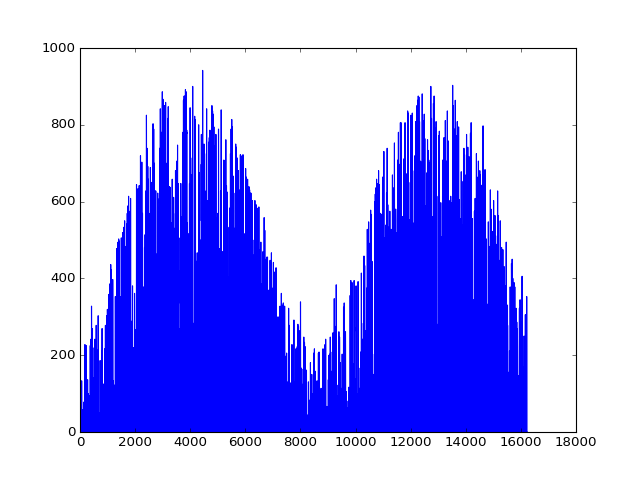

In [15]:
plt.plot(measured)
plt.show()

### Plot below shows only calculated data.
* **global** is determined with PySolar module
    * **global** radiation is corrected with statistical data, based on measurements above.
* **Direct** and **Diffuse** are determined with empirical correlations which are described in *solar engineering for thermal processes *


<IPython.core.display.Javascript object>


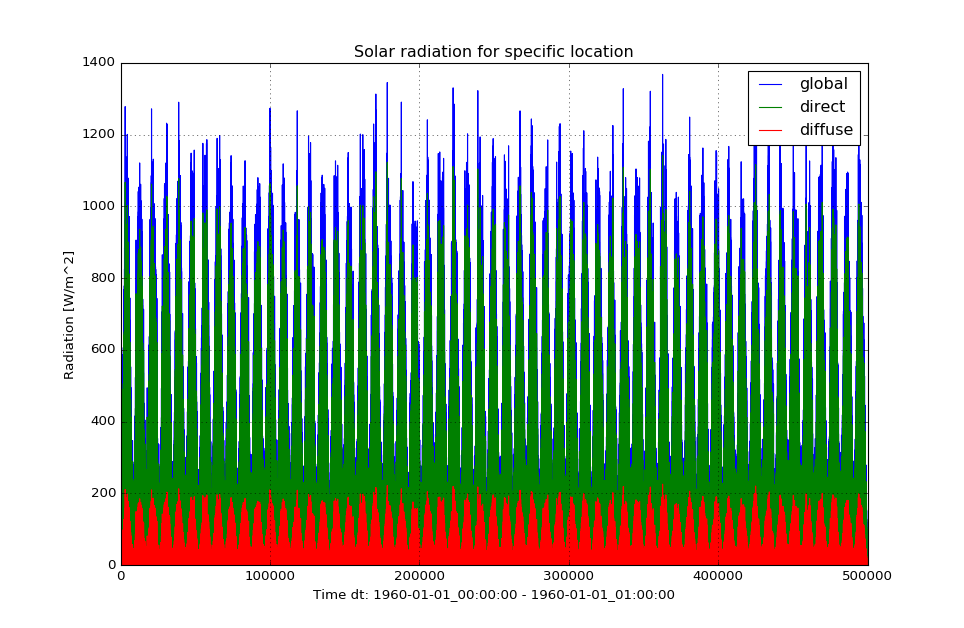

In [48]:
PlotSample(sample)

## Normal distribution from NP (np.random.normal(mean,stdev,amount)
* Has disadvantages:
    * Standard-deviation and mean value are close to measured set but minimum and maximum values are unrealistic
    
    
# Good estimations can be made, but truncated normal distributions are needed!    
    
## Scipy.stats.truncnorm.rvs() is more advanced
* advantages: 
    * Allows for scaling of normal distribution. Min and Max value of measurements are needed for this. 
    * Results in distribution which is very close to measurements
        * Stdev, mean, min and max value end up very close to measured set.
* Disadvantages:
    * Returns errors when Stdev, mean, min or max equals 0
        * To overcome this: all (Stdev, mean, min or max) <= 0.0: set to: 1e-16
        
### Result:
* np.random.normal(mean,stdev,len(array)) is replaced with: TND(stdev,mean,Min,Max,len(Array))
    * which is a wrapper for the Scipy.stats.truncnorm.rvs() method.
#NormDist = TND(stdev,mean,Min,Max,len(Array))
#NormDist = np.random.normal(mean,stdev,len(Array))

In [3]:
# Single executable test:
import datetime
import csv
import Get_Radiation as R
import matplotlib.pyplot as plt #pip install matplotlib
import numpy as np # pip install numpy
%matplotlib notebook  

HourData,HourDataKt = R.CalculateLocalVariation("KNMI_20171107_hourly.txt",5.18,52.1)

testhour = HourData[3006]
stdev,mean,median,variance, Min, Max= R.CalcStats(testhour,True)
bc = np.random.normal(mean,stdev,len(testhour))
plt.plot(bc)
plt.plot(testhour)
plt.show()

HourStats = R.CalcStatsSet(HourData)
print len(HourStats)
print len(HourData)
R.ToCSV("Stats_DeBilt_2017.csv", HourStats, fieldnames = ["mu","sigma","median","variance","min","max"])
hour = R.GetKx()
RestoredStats = R.GetStats()
print len(RestoredStats)
testhour = RestoredStats[3006]
print testhour

sample = R.CalcRad("2016-1-1","2016-12-18",5.180,52.100,900)

measured = []
with open("5-180_52-100.csv",'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        measured.append(float((int(row["Q"])*100*100))/900)
        
Qgc = []
for i in sample:
    Qgc.append(i[1])
print "standard deviation:, mean:,       median:,    variance:,          min:, max:"
print CalcStats(Qgc)
print CalcStats(measured)

plt.plot(measured,label='measured')
PlotSample(sample)

plt.plot(measured)
plt.show()

PlotSample(sample)

def PlotSample(sample):
    date = []
    glob = []
    Dir = []
    Dif = []
    for i in sample:
        date.append(i[0])
        glob.append(i[1])
        Dir.append(i[2])
        Dif.append(i[3])
    g = plt.plot(glob, label='global')
    gdir = plt.plot(Dir, label='direct')
    gdif = plt.plot(Dif, label='diffuse')
    plt.ylabel('Radiation [W/m^2]')
    plt.xlabel('Time dt: {} - {}'.format(date[0],date[1]))
    plt.title('Solar radiation for specific location')
    plt.grid(True)
    plt.legend()
    plt.show()

IOError: [Errno 2] No such file or directory: 'KNMI_20171107_hourly.txt.csv'